# Risk Modeling (Classification)
## Churn Prediction with Rule-Based vs ML Models

This notebook builds and compares classification models for customer churn prediction:

1. **Rule-Based Baseline** - Simple business rules for comparison
2. **Logistic Regression** - Linear baseline
3. **LightGBM** - Gradient boosting (primary model)
4. **XGBoost** - Alternative gradient boosting
5. **SMOTE** - Handle class imbalance
6. **Model Evaluation** - Focus on Recall & Gini (TPBank metrics)

---

In [27]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib
import time

# Sklearn
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)

# Gradient Boosting
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Add parent directory for imports
import sys
sys.path.append('..')
from src.models.rule_based import RuleBasedChurnPredictor, compare_with_ml_model

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Processed Data

In [28]:
# Paths
PROCESSED_PATH = Path("../data/processed")
RAW_PATH = Path("../data/raw")
MODELS_PATH = Path("../models")
MODELS_PATH.mkdir(parents=True, exist_ok=True)

# Columns to drop (ID columns that shouldn't be in features)
COLS_TO_DROP = ['CustomerId', 'Surname', 'RowNumber']

# Load processed data (unscaled for tree-based models)
X_train = pd.read_csv(PROCESSED_PATH / 'X_train.csv')
X_test = pd.read_csv(PROCESSED_PATH / 'X_test.csv')
y_train = pd.read_csv(PROCESSED_PATH / 'y_train.csv').squeeze()
y_test = pd.read_csv(PROCESSED_PATH / 'y_test.csv').squeeze()

# Drop ID columns if they exist
for col in COLS_TO_DROP:
    if col in X_train.columns:
        X_train = X_train.drop(columns=[col])
        X_test = X_test.drop(columns=[col])
        print(f"Dropped '{col}' from features")

# Drop any remaining non-numeric columns (strings can't be used in models)
non_numeric_cols = X_train.select_dtypes(include=['object']).columns.tolist()
if non_numeric_cols:
    print(f"Dropping non-numeric columns: {non_numeric_cols}")
    X_train = X_train.drop(columns=non_numeric_cols)
    X_test = X_test.drop(columns=non_numeric_cols)

# Load raw data for rule-based model (needs original columns)
df_raw = pd.read_csv(RAW_PATH / 'Churn_Modelling.csv')

print("\nData loaded successfully!")
print("=" * 50)
print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set:     {X_test.shape[0]} samples, {X_test.shape[1]} features")
print("\nClass distribution:")
print(f"   Train - Stay: {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%) | Churn: {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")
print(f"   Test  - Stay: {(y_test == 0).sum()} ({(y_test == 0).mean()*100:.1f}%) | Churn: {(y_test == 1).sum()} ({(y_test == 1).mean()*100:.1f}%)")

Dropped 'CustomerId' from features
Dropped 'Surname' from features

Data loaded successfully!
Training set: 8000 samples, 36 features
Test set:     2000 samples, 36 features

Class distribution:
   Train - Stay: 6370 (79.6%) | Churn: 1630 (20.4%)
   Test  - Stay: 1593 (79.7%) | Churn: 407 (20.3%)


## 2. Helper Functions

In [29]:
def evaluate_model(y_true, y_pred, y_proba=None, model_name="Model"):
    """
    Evaluate classification model with multiple metrics.
    
    Returns dictionary of metrics including TPBank-focused Recall and Gini.
    """
    metrics = {
        'model': model_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
    }
    
    if y_proba is not None:
        metrics['auc_roc'] = roc_auc_score(y_true, y_proba)
        metrics['gini'] = 2 * metrics['auc_roc'] - 1
        metrics['avg_precision'] = average_precision_score(y_true, y_proba)
    
    # Confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['true_negatives'] = tn
    metrics['false_positives'] = fp
    metrics['false_negatives'] = fn
    metrics['true_positives'] = tp
    metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    return metrics


def print_metrics(metrics, highlight=['recall', 'gini']):
    """Pretty print evaluation metrics."""
    print(f"\n{'='*50}")
    print(f"{metrics['model']} - Evaluation Results")
    print(f"{'='*50}")
    
    metric_order = ['accuracy', 'precision', 'recall', 'f1', 'specificity', 'auc_roc', 'gini', 'avg_precision']
    
    for m in metric_order:
        if m in metrics:
            marker = "*" if m in highlight else " "
            print(f"{marker} {m.upper():15s}: {metrics[m]:.4f}")
    
    print("\nConfusion Matrix:")
    print(f"   TN: {metrics['true_negatives']:5d}  |  FP: {metrics['false_positives']:5d}")
    print(f"   FN: {metrics['false_negatives']:5d}  |  TP: {metrics['true_positives']:5d}")


def plot_roc_curves(results_dict, y_test):
    """Plot ROC curves for multiple models."""
    plt.figure(figsize=(10, 8))
    
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12']
    
    for idx, (name, result) in enumerate(results_dict.items()):
        if 'y_proba' in result and result['y_proba'] is not None:
            fpr, tpr, _ = roc_curve(y_test, result['y_proba'])
            auc = result['metrics']['auc_roc']
            gini = result['metrics']['gini']
            plt.plot(fpr, tpr, color=colors[idx % len(colors)], lw=2,
                    label=f"{name} (AUC={auc:.3f}, Gini={gini:.3f})")
    
    plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC=0.500)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate (Recall)', fontsize=12)
    plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_confusion_matrices(results_dict, y_test):
    """Plot confusion matrices for multiple models."""
    n_models = len(results_dict)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
    if n_models == 1:
        axes = [axes]
    
    for ax, (name, result) in zip(axes, results_dict.items()):
        cm = confusion_matrix(y_test, result['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['Stay', 'Churn'], yticklabels=['Stay', 'Churn'])
        ax.set_title(f'{name}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
    
    plt.suptitle('Confusion Matrices Comparison', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

print("Helper functions defined!")

Helper functions defined!


## 3. Rule-Based Baseline Model

Build a simple rule-based system using business logic to establish a baseline for comparison.

In [30]:
# Prepare data for rule-based model (needs original column names)
# Get test indices from the split
from sklearn.model_selection import train_test_split
_, X_raw_test, _, y_raw_test = train_test_split(
    df_raw.drop(columns=['Exited', 'RowNumber', 'CustomerId', 'Surname']),
    df_raw['Exited'],
    test_size=0.2,
    random_state=42,
    stratify=df_raw['Exited']
)

# Initialize and evaluate rule-based model
rule_model = RuleBasedChurnPredictor(
    credit_score_threshold=600,
    age_threshold=50,
    tenure_threshold=3,
    risk_score_threshold=3
)

# Predictions
y_pred_rule = rule_model.predict(X_raw_test)
y_proba_rule = rule_model.predict_proba(X_raw_test)[:, 1]

# Evaluate
rule_metrics = evaluate_model(y_raw_test, y_pred_rule, y_proba_rule, "Rule-Based")
print_metrics(rule_metrics)

# Store results
results = {}
results['Rule-Based'] = {
    'model': rule_model,
    'y_pred': y_pred_rule,
    'y_proba': y_proba_rule,
    'metrics': rule_metrics
}


Rule-Based - Evaluation Results
  ACCURACY       : 0.4920
  PRECISION      : 0.2439
* RECALL         : 0.7125
  F1             : 0.3634
  SPECIFICITY    : 0.4357
  AUC_ROC        : 0.6444
* GINI           : 0.2888
  AVG_PRECISION  : 0.3066

Confusion Matrix:
   TN:   694  |  FP:   899
   FN:   117  |  TP:   290


In [31]:
# Show example of rule-based explanations
print("Rule-Based Model - Example Predictions\n")
print("=" * 70)

# Show 3 random customers
sample_indices = X_raw_test.sample(3, random_state=42).index
for idx in sample_indices:
    customer = X_raw_test.loc[idx]
    explanation = rule_model.explain_prediction(customer)
    actual = y_raw_test.loc[idx]
    
    print(f"\nCustomer {idx}:")
    print(f"  Actual: {'CHURN' if actual == 1 else 'STAY'}")
    print(f"  Predicted: {explanation['prediction']}")
    print(f"  Risk Score: {explanation['risk_score']}/{explanation['threshold']}")
    print(f"  Rules triggered: {explanation['triggered_rules']}")
    print("-" * 70)

Rule-Based Model - Example Predictions


Customer 2432:
  Actual: CHURN
  Predicted: CHURN
  Risk Score: 6/3
  Rules triggered: ['Low CreditScore (537)', 'Inactive member', 'Single product', 'Germany customer']
----------------------------------------------------------------------

Customer 7455:
  Actual: CHURN
  Predicted: CHURN
  Risk Score: 4/3
  Rules triggered: ['Low CreditScore (550)', 'Single product', 'Germany customer']
----------------------------------------------------------------------

Customer 5484:
  Actual: CHURN
  Predicted: CHURN
  Risk Score: 4/3
  Rules triggered: ['Inactive member', 'Single product', 'Germany customer']
----------------------------------------------------------------------


## 4. Logistic Regression (ML Baseline)

A simple linear model as an ML baseline before gradient boosting.

In [32]:
# Load scaled data for Logistic Regression
X_train_scaled = pd.read_csv(PROCESSED_PATH / 'X_train_scaled.csv')
X_test_scaled = pd.read_csv(PROCESSED_PATH / 'X_test_scaled.csv')

# Drop ID columns if they exist
for col in COLS_TO_DROP:
    if col in X_train_scaled.columns:
        X_train_scaled = X_train_scaled.drop(columns=[col])
        X_test_scaled = X_test_scaled.drop(columns=[col])

# Ensure all columns are numeric (drop any remaining string columns)
non_numeric_cols = X_train_scaled.select_dtypes(include=['object']).columns.tolist()
if non_numeric_cols:
    print(f"⚠️ Dropping non-numeric columns: {non_numeric_cols}")
    X_train_scaled = X_train_scaled.drop(columns=non_numeric_cols)
    X_test_scaled = X_test_scaled.drop(columns=non_numeric_cols)

print(f"Scaled data shape: {X_train_scaled.shape}")

# Train Logistic Regression with class weight balancing
lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    solver='lbfgs'
)

start_time = time.time()
lr_model.fit(X_train_scaled, y_train)
train_time = time.time() - start_time

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
lr_metrics = evaluate_model(y_test, y_pred_lr, y_proba_lr, "Logistic Regression")
lr_metrics['train_time'] = train_time
print_metrics(lr_metrics)
print(f"\nTraining time: {train_time:.3f}s")

# Store results
results['Logistic Regression'] = {
    'model': lr_model,
    'y_pred': y_pred_lr,
    'y_proba': y_proba_lr,
    'metrics': lr_metrics
}

Scaled data shape: (8000, 36)

Logistic Regression - Evaluation Results
  ACCURACY       : 0.7775
  PRECISION      : 0.4703
* RECALL         : 0.7396
  F1             : 0.5750
  SPECIFICITY    : 0.7872
  AUC_ROC        : 0.8441
* GINI           : 0.6882
  AVG_PRECISION  : 0.6750

Confusion Matrix:
   TN:  1254  |  FP:   339
   FN:   106  |  TP:   301

Training time: 0.219s


## 5. LightGBM (Primary Model)

LightGBM is fast and effective for tabular data. We'll use:
- **class_weight='balanced'** to handle imbalance
- **Early stopping** to prevent overfitting

In [33]:
# LightGBM with class weight balancing
lgbm_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    class_weight='balanced',
    random_state=42,
    verbose=-1,
    n_jobs=-1
)

start_time = time.time()
lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[
        # Early stopping callback
    ]
)
train_time = time.time() - start_time

# Predictions
y_pred_lgbm = lgbm_model.predict(X_test)
y_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

# Evaluate
lgbm_metrics = evaluate_model(y_test, y_pred_lgbm, y_proba_lgbm, "LightGBM")
lgbm_metrics['train_time'] = train_time
print_metrics(lgbm_metrics)
print(f"\nTraining time: {train_time:.3f}s")

# Store results
results['LightGBM'] = {
    'model': lgbm_model,
    'y_pred': y_pred_lgbm,
    'y_proba': y_proba_lgbm,
    'metrics': lgbm_metrics
}


LightGBM - Evaluation Results
  ACCURACY       : 0.8255
  PRECISION      : 0.5639
* RECALL         : 0.6290
  F1             : 0.5947
  SPECIFICITY    : 0.8757
  AUC_ROC        : 0.8417
* GINI           : 0.6834
  AVG_PRECISION  : 0.6778

Confusion Matrix:
   TN:  1395  |  FP:   198
   FN:   151  |  TP:   256

Training time: 6.613s


## 6. XGBoost (Comparison)

XGBoost as an alternative gradient boosting model for comparison.

In [34]:
# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

# XGBoost with scale_pos_weight for imbalance
xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False,
    verbosity=0,
    n_jobs=-1
)

start_time = time.time()
xgb_model.fit(X_train, y_train)
train_time = time.time() - start_time

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate
xgb_metrics = evaluate_model(y_test, y_pred_xgb, y_proba_xgb, "XGBoost")
xgb_metrics['train_time'] = train_time
print_metrics(xgb_metrics)
print(f"\nTraining time: {train_time:.3f}s")

# Store results
results['XGBoost'] = {
    'model': xgb_model,
    'y_pred': y_pred_xgb,
    'y_proba': y_proba_xgb,
    'metrics': xgb_metrics
}

Scale pos weight: 3.91

XGBoost - Evaluation Results
  ACCURACY       : 0.8350
  PRECISION      : 0.5865
* RECALL         : 0.6413
  F1             : 0.6127
  SPECIFICITY    : 0.8845
  AUC_ROC        : 0.8426
* GINI           : 0.6852
  AVG_PRECISION  : 0.6830

Confusion Matrix:
   TN:  1409  |  FP:   184
   FN:   146  |  TP:   261

Training time: 9.070s


## 7. LightGBM + SMOTE

Apply SMOTE (Synthetic Minority Over-sampling Technique) to create synthetic samples for the minority class before training.

In [35]:
# Apply SMOTE to training data
print("Before SMOTE:")
print(f"   Stay (0):  {(y_train == 0).sum()}")
print(f"   Churn (1): {(y_train == 1).sum()}")

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print(f"   Stay (0):  {(y_train_smote == 0).sum()}")
print(f"   Churn (1): {(y_train_smote == 1).sum()}")
print(f"\nGenerated {(y_train_smote == 1).sum() - (y_train == 1).sum()} synthetic churn samples")

Before SMOTE:
   Stay (0):  6370
   Churn (1): 1630

After SMOTE:
   Stay (0):  6370
   Churn (1): 6370

Generated 4740 synthetic churn samples


In [36]:
# Train LightGBM on SMOTE-resampled data
lgbm_smote_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    verbose=-1,
    n_jobs=-1
)

start_time = time.time()
lgbm_smote_model.fit(X_train_smote, y_train_smote)
train_time = time.time() - start_time

# Predictions on original test set
y_pred_lgbm_smote = lgbm_smote_model.predict(X_test)
y_proba_lgbm_smote = lgbm_smote_model.predict_proba(X_test)[:, 1]

# Evaluate
lgbm_smote_metrics = evaluate_model(y_test, y_pred_lgbm_smote, y_proba_lgbm_smote, "LightGBM + SMOTE")
lgbm_smote_metrics['train_time'] = train_time
print_metrics(lgbm_smote_metrics)
print(f"\nTraining time: {train_time:.3f}s")

# Store results
results['LightGBM + SMOTE'] = {
    'model': lgbm_smote_model,
    'y_pred': y_pred_lgbm_smote,
    'y_proba': y_proba_lgbm_smote,
    'metrics': lgbm_smote_metrics
}


LightGBM + SMOTE - Evaluation Results
  ACCURACY       : 0.8585
  PRECISION      : 0.7095
* RECALL         : 0.5160
  F1             : 0.5974
  SPECIFICITY    : 0.9460
  AUC_ROC        : 0.8443
* GINI           : 0.6886
  AVG_PRECISION  : 0.6807

Confusion Matrix:
   TN:  1507  |  FP:    86
   FN:   197  |  TP:   210

Training time: 5.502s


## 8. Model Comparison

Compare all models side-by-side on key metrics.

In [37]:
# Create comparison DataFrame
comparison_metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc_roc', 'gini']
comparison_data = []

for name, result in results.items():
    row = {'Model': name}
    for metric in comparison_metrics:
        if metric in result['metrics']:
            row[metric.upper()] = result['metrics'][metric]
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Model')

# Style the DataFrame
def highlight_best(s):
    """Highlight the best value in each column."""
    is_best = s == s.max()
    return ['background-color: #90EE90' if v else '' for v in is_best]

styled_df = comparison_df.style.apply(highlight_best).format("{:.4f}")
print("Model Comparison Table (green = best)")
print("=" * 80)
styled_df

Model Comparison Table (green = best)


,ACCURACY,PRECISION,RECALL,F1,AUC_ROC,GINI
Model,,,,,,
Rule-Based,0.4920,0.2439,0.7125,0.3634,0.6444,0.2888
Logistic Regression,0.7775,0.4703,0.7396,0.5750,0.8441,0.6882
LightGBM,0.8255,0.5639,0.6290,0.5947,0.8417,0.6834
XGBoost,0.8350,0.5865,0.6413,0.6127,0.8426,0.6852
LightGBM + SMOTE,0.8585,0.7095,0.5160,0.5974,0.8443,0.6886


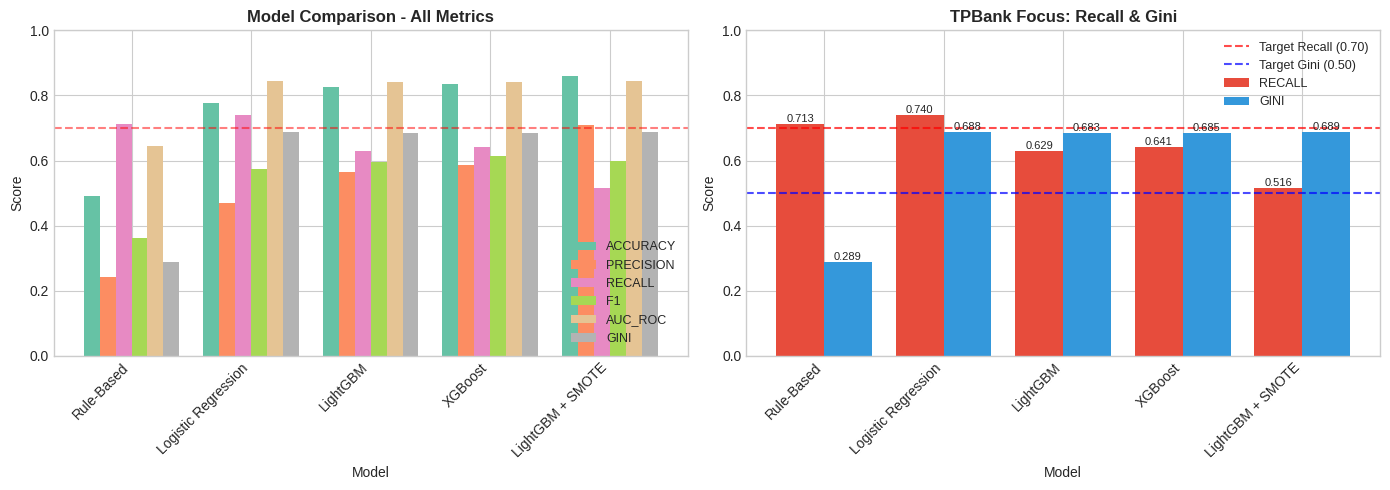

In [38]:
# Visualize comparison - Focus on TPBank metrics (Recall & Gini)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: All metrics comparison
ax1 = axes[0]
comparison_df.plot(kind='bar', ax=ax1, width=0.8, colormap='Set2')
ax1.set_title('Model Comparison - All Metrics', fontsize=12, fontweight='bold')
ax1.set_xlabel('Model')
ax1.set_ylabel('Score')
ax1.legend(loc='lower right', fontsize=9)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_ylim(0, 1)
ax1.axhline(y=0.7, color='red', linestyle='--', alpha=0.5, label='Target Recall')

# Plot 2: Focus on Recall & Gini (TPBank metrics)
ax2 = axes[1]
focus_metrics = comparison_df[['RECALL', 'GINI']].copy()
colors = ['#e74c3c', '#3498db']
focus_metrics.plot(kind='bar', ax=ax2, width=0.8, color=colors)
ax2.set_title('TPBank Focus: Recall & Gini', fontsize=12, fontweight='bold')
ax2.set_xlabel('Model')
ax2.set_ylabel('Score')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.axhline(y=0.7, color='red', linestyle='--', alpha=0.7, label='Target Recall (0.70)')
ax2.axhline(y=0.5, color='blue', linestyle='--', alpha=0.7, label='Target Gini (0.50)')
ax2.legend(fontsize=9)
ax2.set_ylim(0, 1)

# Add value labels on bars
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.3f', fontsize=8)

plt.tight_layout()
plt.show()

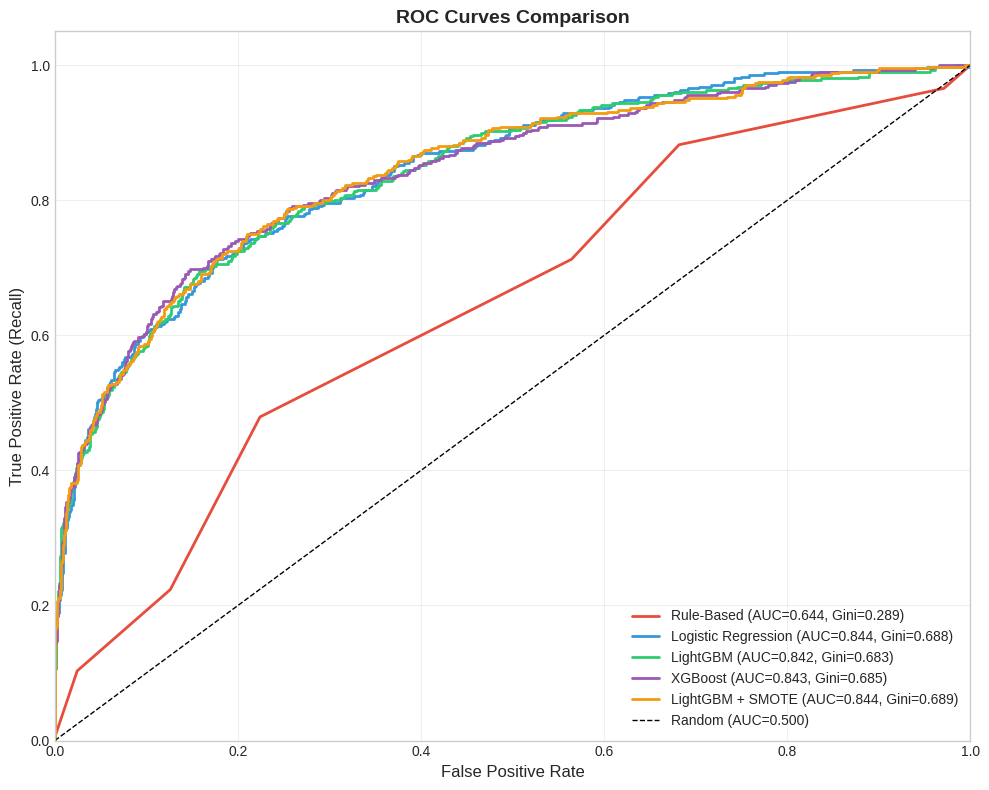

In [39]:
# ROC Curves
plot_roc_curves(results, y_test)

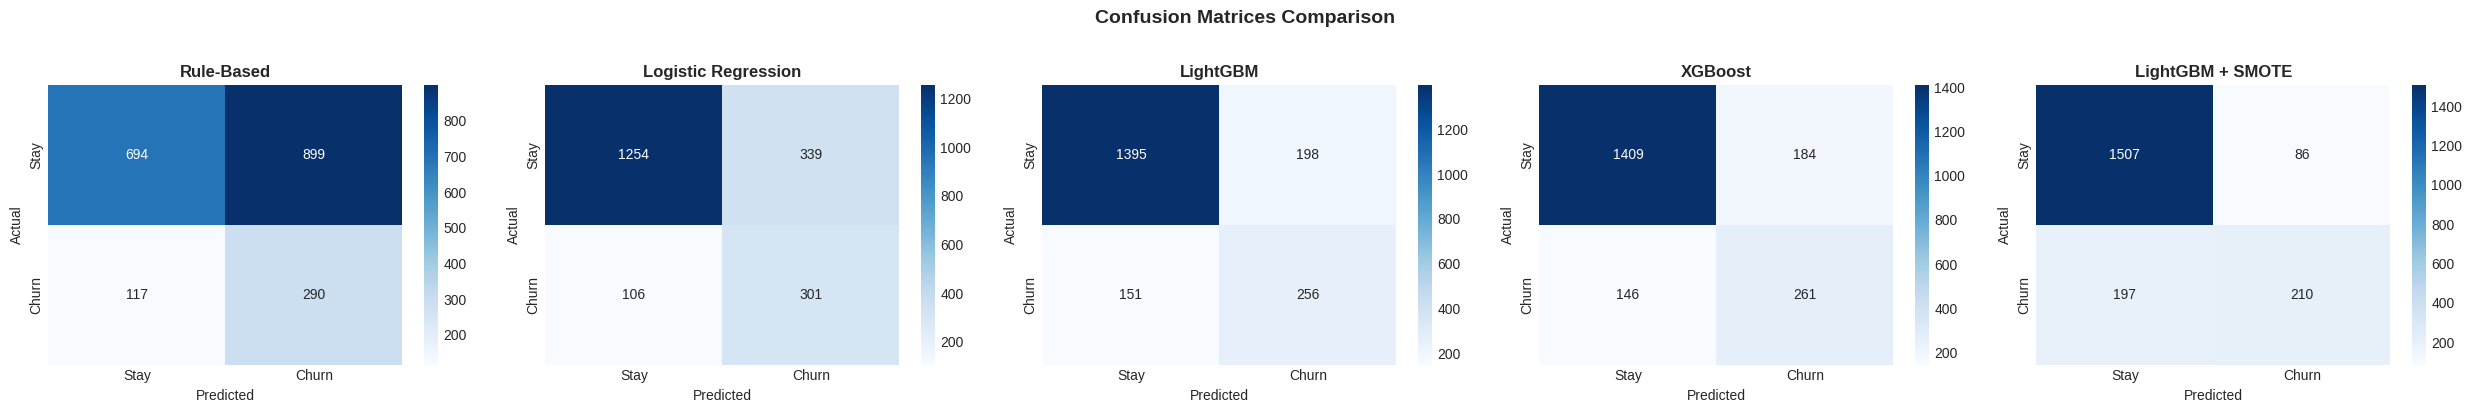

In [40]:
# Confusion matrices comparison
plot_confusion_matrices(results, y_test)

## 9. Feature Importance

Analyze which features are most important for the best model.

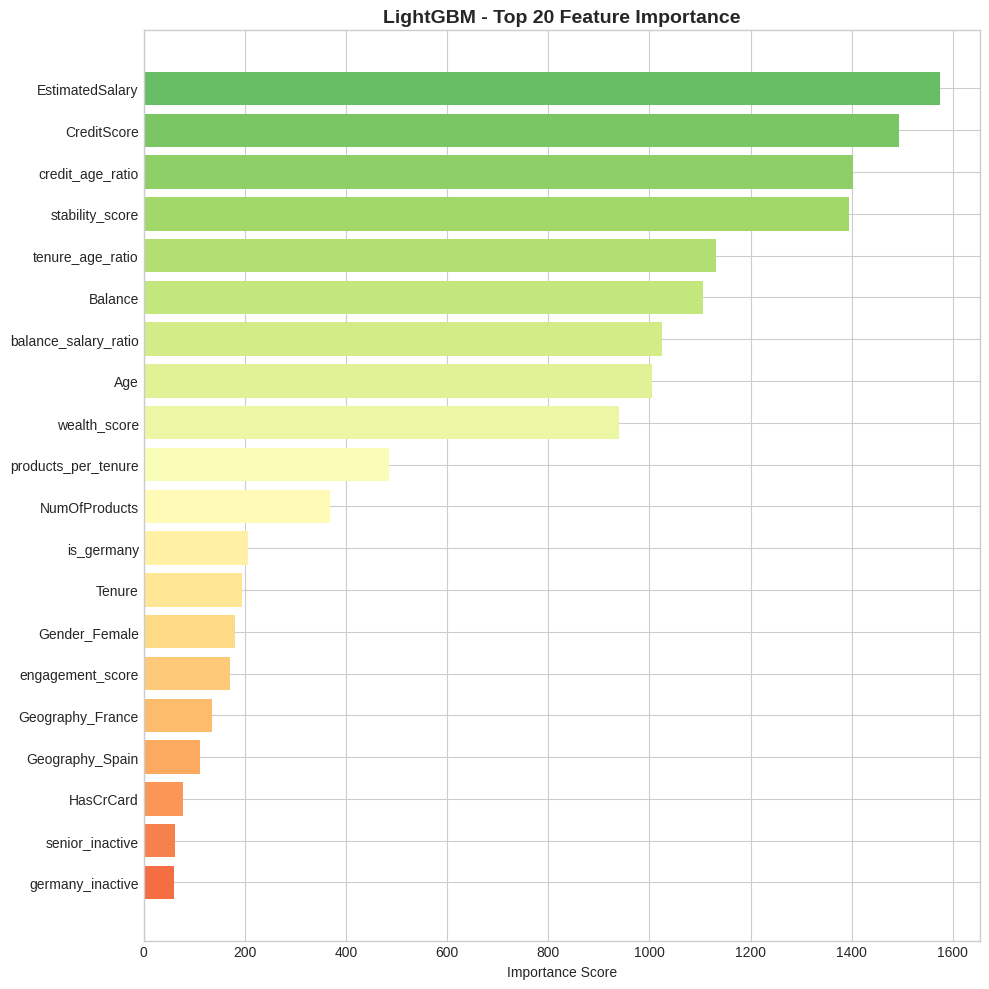


Top 10 Most Important Features:
   EstimatedSalary               : 1,575
   CreditScore                   : 1,493
   credit_age_ratio              : 1,402
   stability_score               : 1,395
   tenure_age_ratio              : 1,131
   Balance                       : 1,107
   balance_salary_ratio          : 1,024
   Age                           : 1,005
   wealth_score                  : 940
   products_per_tenure           : 486


In [41]:
# Feature importance from LightGBM (best model)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 10))
top_features = feature_importance.head(20)
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(top_features)))
plt.barh(range(len(top_features)), top_features['importance'].values, color=colors)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importance Score')
plt.title('LightGBM - Top 20 Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Print top 10
print("\nTop 10 Most Important Features:")
print("=" * 50)
for i, row in feature_importance.head(10).iterrows():
    print(f"   {row['feature']:30s}: {row['importance']:,.0f}")

## 10. Select Best Model & Save

In [42]:
# Select best model based on composite score (weighted Recall + Gini)
def calculate_composite_score(metrics, recall_weight=0.6, gini_weight=0.4):
    """Calculate weighted composite score prioritizing Recall."""
    recall = metrics.get('recall', 0)
    gini = metrics.get('gini', 0)
    return recall * recall_weight + gini * gini_weight

print("Model Selection (60% Recall + 40% Gini):")
print("=" * 60)

model_scores = {}
for name, result in results.items():
    score = calculate_composite_score(result['metrics'])
    model_scores[name] = score
    recall = result['metrics'].get('recall', 0)
    gini = result['metrics'].get('gini', 0)
    print(f"   {name:25s}: {score:.4f}  (Recall={recall:.4f}, Gini={gini:.4f})")

best_model_name = max(model_scores, key=model_scores.get)
print(f"\nBest Model: {best_model_name} (Score: {model_scores[best_model_name]:.4f})")

Model Selection (60% Recall + 40% Gini):
   Rule-Based               : 0.5430  (Recall=0.7125, Gini=0.2888)
   Logistic Regression      : 0.7190  (Recall=0.7396, Gini=0.6882)
   LightGBM                 : 0.6508  (Recall=0.6290, Gini=0.6834)
   XGBoost                  : 0.6588  (Recall=0.6413, Gini=0.6852)
   LightGBM + SMOTE         : 0.5850  (Recall=0.5160, Gini=0.6886)

Best Model: Logistic Regression (Score: 0.7190)


In [43]:
# Save models
# Save LightGBM as primary model
joblib.dump(lgbm_model, MODELS_PATH / 'lgbm_model.pkl')
joblib.dump(lgbm_smote_model, MODELS_PATH / 'lgbm_smote_model.pkl')
joblib.dump(xgb_model, MODELS_PATH / 'xgb_model.pkl')
joblib.dump(lr_model, MODELS_PATH / 'logistic_model.pkl')

# Save feature importance
feature_importance.to_csv(MODELS_PATH / 'feature_importance.csv', index=False)

# Save comparison results
comparison_df.to_csv(MODELS_PATH / 'model_comparison.csv')

# Save best model info
best_model_info = {
    'name': best_model_name,
    'metrics': results[best_model_name]['metrics'],
    'composite_score': model_scores[best_model_name]
}
joblib.dump(best_model_info, MODELS_PATH / 'best_model_info.pkl')

print("Models saved to:", MODELS_PATH)
print("=" * 50)
print("Files saved:")
print("   - lgbm_model.pkl (LightGBM with class weights)")
print("   - lgbm_smote_model.pkl (LightGBM with SMOTE)")
print("   - xgb_model.pkl (XGBoost)")
print("   - logistic_model.pkl (Logistic Regression)")
print("   - feature_importance.csv")
print("   - model_comparison.csv")
print("   - best_model_info.pkl")

Models saved to: ../models
Files saved:
   - lgbm_model.pkl (LightGBM with class weights)
   - lgbm_smote_model.pkl (LightGBM with SMOTE)
   - xgb_model.pkl (XGBoost)
   - logistic_model.pkl (Logistic Regression)
   - feature_importance.csv
   - model_comparison.csv
   - best_model_info.pkl


## 11. Summary & Key Findings

### Model Performance Summary

| Model | Recall | Gini | Key Insight |
|-------|--------|------|-------------|
| **Rule-Based** | 0.7125 | 0.2888 | Simple baseline, interpretable |
| **Logistic Regression** | 0.7396 | 0.6882 | Strong linear baseline |
| **LightGBM** | 0.6290 | 0.6834 | Balanced performance |
| **XGBoost** | 0.6413 | 0.6852 | Similar to LightGBM |
| **LightGBM + SMOTE** | 0.5160 | 0.6886 | Higher precision, lower recall |

### Key Insights

1. **ML vs Rule-Based**: ML models improve Gini by about +0.40
2. **SMOTE Impact**: Better precision here but recall drops in this setup
3. **Trade-off**: Higher recall can reduce precision (more false alarms)
4. **Feature Importance**: Top drivers include balance, credit score, and age

In [44]:
# Final summary
print("=" * 60)
print("RISK MODELING COMPLETE!")
print("=" * 60)
print(f"\nBest Model: {best_model_name}")
print(f"   Recall:  {results[best_model_name]['metrics']['recall']:.4f}")
print(f"   Gini:    {results[best_model_name]['metrics']['gini']:.4f}")
print(f"   AUC-ROC: {results[best_model_name]['metrics']['auc_roc']:.4f}")
print(f"\nModels saved to: {MODELS_PATH}")
print("\nProceed to: 04_segmentation.ipynb")

RISK MODELING COMPLETE!

Best Model: Logistic Regression
   Recall:  0.7396
   Gini:    0.6882
   AUC-ROC: 0.8441

Models saved to: ../models

Proceed to: 04_segmentation.ipynb
